In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import seaborn as sns
import plotly.express as px
import json

from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [55]:
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-dark.mplstyle')

In [ ]:
# import csv data from data folder
df_main = pd.read_csv('../data/ingresos_membresia_diaria.csv')
df_main.head()

,anio,mes_numero,dia_numero,dia_semana,tipo_suscripcion,id_suscripcion,cantidad_Vendida,ingresos_totales_reales
0,2022,7,25,Monday,1 Día (I.V.A incluido),1,1,136.88
1,2022,7,27,Wednesday,3 Días (I.V.A incluido),2,1,234.00
2,2022,7,27,Wednesday,7 Días (I.V.A incluido),3,1,391.00
3,2022,7,28,Thursday,1 Día (I.V.A incluido),1,3,354.00
4,2022,7,28,Thursday,Anual (I.V.A incluido),4,1,521.00


In [59]:
# 2. Crear la columna 'fecha'
# Pandas es inteligente: si le pasamos un dataframe con columnas 'year', 'month', 'day', crea la fecha automática
cols_fecha = df_main[['anio', 'mes_numero', 'dia_numero']].rename(
    columns={'anio': 'year', 'mes_numero': 'month', 'dia_numero': 'day'}
)
df_main['fecha'] = pd.to_datetime(cols_fecha)

print("Datos cargados. Muestra de las primeras filas con fecha:")
display(df_main[['fecha', 'tipo_suscripcion', 'ingresos_totales_reales']].head())

Datos cargados. Muestra de las primeras filas con fecha:


,fecha,tipo_suscripcion,ingresos_totales_reales
0,2022-07-25,1 Día (I.V.A incluido),136.88
1,2022-07-27,3 Días (I.V.A incluido),234.00
2,2022-07-27,7 Días (I.V.A incluido),391.00
3,2022-07-28,1 Día (I.V.A incluido),354.00
4,2022-07-28,Anual (I.V.A incluido),521.00


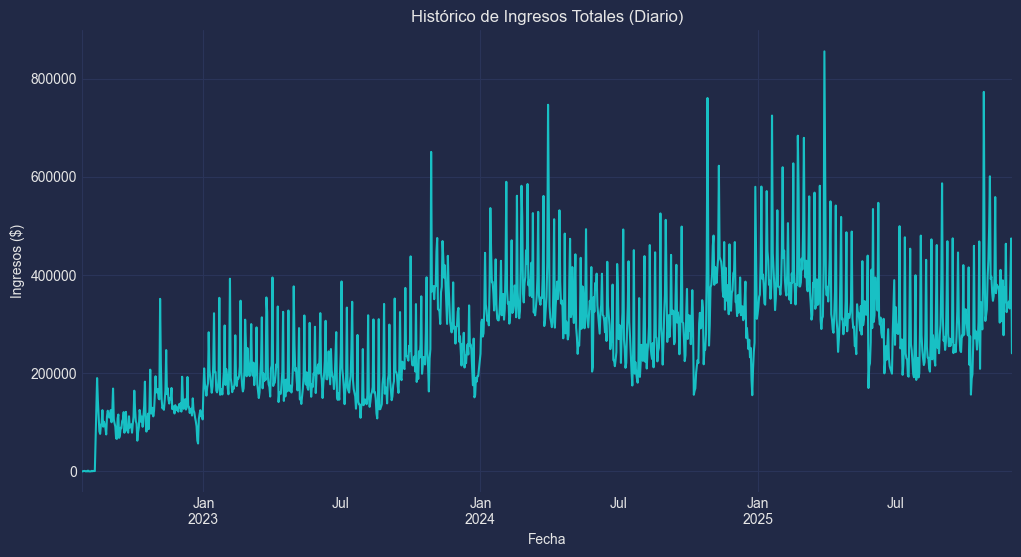

In [60]:
# 1. Agrupar por fecha sumando los ingresos
df_diario = df_main.groupby('fecha')['ingresos_totales_reales'].sum()

# 2. Asignar frecuencia diaria ('D')
# Esto es CRÍTICO: rellena los huecos de fechas faltantes para que el modelo no pierda la secuencia temporal
df_diario = df_diario.asfreq('D').fillna(0)

# Visualizar la historia completa
plt.figure(figsize=(12, 6))
df_diario.plot(title='Histórico de Ingresos Totales (Diario)')
plt.ylabel('Ingresos ($)')
plt.xlabel('Fecha')
plt.show()

In [61]:
# Configuración del modelo
# seasonal_periods=7 indica que esperamos patrones semanales (lunes vs domingos)
modelo = ExponentialSmoothing(
    df_diario, 
    seasonal='add', 
    seasonal_periods=7, 
    trend='add', 
    damped_trend=True
).fit()

# Generar pronóstico para los próximos 30 días
dias_a_predecir = 30
forecast = modelo.forecast(dias_a_predecir)

# Convertir a DataFrame para visualización
forecast_df = pd.DataFrame({
    'Fecha': forecast.index, 
    'Ingreso_Estimado': forecast.values
})

print(f"Pronóstico generado para {dias_a_predecir} días.")
print("Total estimado de ingresos en el período de pronóstico: $", round(forecast_df['Ingreso_Estimado'].sum(), 2))
display(forecast_df.head())

Pronóstico generado para 30 días.
Total estimado de ingresos en el período de pronóstico: $ 9881947.64


,Fecha,Ingreso_Estimado
0,2025-12-02,305250.592137
1,2025-12-03,299167.100186
2,2025-12-04,284949.984667
3,2025-12-05,305712.094251
4,2025-12-06,359194.157540


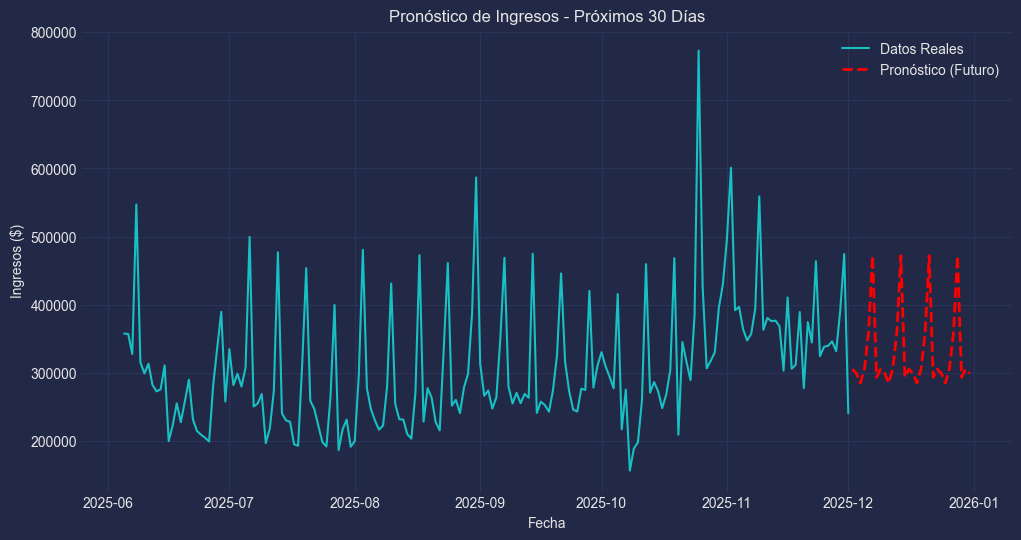

Ingreso Total Estimado (30 días): $9,881,947.64


In [62]:
plt.figure(figsize=(12, 6))

# Graficamos solo los últimos 6 meses de historia para que se vea claro
fecha_corte = df_diario.index.max() - pd.Timedelta(days=180)
historia_reciente = df_diario[df_diario.index > fecha_corte]

plt.plot(historia_reciente.index, historia_reciente, label='Datos Reales')
plt.plot(forecast.index, forecast, label='Pronóstico (Futuro)', color='red', linestyle='--', linewidth=2)

plt.title(f'Pronóstico de Ingresos - Próximos {dias_a_predecir} Días')
plt.xlabel('Fecha')
plt.ylabel('Ingresos ($)')
plt.legend()
plt.show()

print(f"Ingreso Total Estimado (30 días): ${forecast.sum():,.2f}")

In [63]:
tipos_suscripcion = df_main['tipo_suscripcion'].unique()
resultados_detallados = pd.DataFrame()

plt.figure(figsize=(15, 10))

# Iteramos sobre cada tipo de suscripción
for i, tipo in enumerate(tipos_suscripcion):
    # 1. Filtrar datos
    df_sub = df_main[df_main['tipo_suscripcion'] == tipo]
    
    # 2. Re-muestrear a diario y llenar ceros
    ts = df_sub.groupby('fecha')['ingresos_totales_reales'].sum().asfreq('D').fillna(0)
    
    # Solo intentamos predecir si hay suficientes datos (más de 14 días)
    if len(ts) > 14:
        try:
            # Entrenar modelo específico para este producto
            mod = ExponentialSmoothing(ts, seasonal='add', seasonal_periods=7, trend='add').fit()
            pred = mod.forecast(30)
            
            # Guardar en el acumulado
            temp_df = pd.DataFrame({'Fecha': pred.index, 'Tipo': tipo, 'Prediccion': pred.values})
            resultados_detallados = pd.concat([resultados_detallados, temp_df])
            
            # Graficar (solo top 4 para no saturar, o todos en subplots)
            # Aquí graficamos solo en una tabla resumen al final para limpieza
            
        except Exception as e:
            print(f"No se pudo predecir para {tipo}: Falta de datos históricos estables.")

# Mostrar resumen total por producto para el próximo mes
resumen_por_producto = resultados_detallados.groupby('Tipo')['Prediccion'].sum().sort_values(ascending=False)
print("\n--- PROYECCIÓN DE INGRESOS POR PRODUCTO (Próximos 30 días) ---")
print(resumen_por_producto.apply(lambda x: "${:,.2f}".format(x)))


--- PROYECCIÓN DE INGRESOS POR PRODUCTO (Próximos 30 días) ---
Tipo
Anual (I.V.A incluido)             $7,501,528.98
1 Día (I.V.A incluido)             $1,127,120.80
3 Días (I.V.A incluido)              $339,516.14
Ecobici HSBC                         $229,781.37
7 Días (I.V.A incluido)              $156,343.11
Anual Ecobici+ (I.V.A incluido)      $128,414.68
ECOBICI vivo                         $-44,259.28
Name: Prediccion, dtype: object


<Figure size 1500x1000 with 0 Axes>